<a href="https://colab.research.google.com/github/rimi22duity/NLP-experiments/blob/main/MultilabelClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##**Predict tags on StackOverflow with linear models**
how to predict tags for posts from StackOverflow. To solve this using **multilabel classification approach**.

**Libraries**
In this task, the following libraries are needed:

*   Numpy — a package for scientific computing.
*   Pandas — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
*   scikit-learn — a tool for data mining and data analysis.
*   NLTK — a platform to work with natural language.



#**Data**

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    ! wget https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.setup_week1() 
    
import sys
sys.path.append("..")
from common.download_utils import download_week1_resources

download_week1_resources()

--2021-04-09 22:02:04--  https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1939 (1.9K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.89K  --.-KB/s    in 0s      

2021-04-09 22:02:04 (19.6 MB/s) - ‘setup_google_colab.py’ saved [1939/1939]

File data/train.tsv is already downloaded.
File data/validation.tsv is already downloaded.
File data/test.tsv is already downloaded.
File data/text_prepare_tests.tsv is already downloaded.


#**Grading**

For Coursera 

In [ ]:
from grader import Grader

In [ ]:
grader = Grader()

#**Text preprocessing**
Need to use stop words. It can be downloaded from nltk library as follows:

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In this task I need to deal with a dataset of post titles from StackOverflow. A split to 3 sets of data is provided: train, validation and test. All corpora (except for test) contain titles of the posts and corresponding tags (100 tags are available). The test set is provided for Coursera's grading and doesn't contain answers. Upload the corpora using pandas and look at the data:

In [ ]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [ ]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [ ]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [ ]:
import shutil

original_path_train = r'data/train.tsv'
target_path_train = r'/content/drive/MyDrive/Colab Notebooks/NLP Practice/data/train.tsv'
original_path_validation = r'data/validation.tsv'
target_path_validation = r'/content/drive/MyDrive/Colab Notebooks/NLP Practice/data/validation.tsv'
original_path_test = r'data/test.tsv'
target_path_test = r'/content/drive/MyDrive/Colab Notebooks/NLP Practice/data/test.tsv'

shutil.copyfile(original_path_train, target_path_train)
shutil.copyfile(original_path_validation, target_path_validation)
shutil.copyfile(original_path_test, target_path_test)

'/content/drive/MyDrive/Colab Notebooks/NLP Practice/data/test.tsv'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [ ]:
type(train['tags'].iloc[0])

list

It could be noticed that a number of tags for a post is not fixed and could be as many as necessary.

For a more comfortable usage, initialize X_train, X_val, X_test, y_train, y_val.

In [ ]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [ ]:
X_train[:36]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app',
 'get current time specific country via jquery',
 'configuring tomcat use ssl',
 'awesome nested set plugin add new children tree various levels',
 'create map json response ruby rails 3',
 'rspec test method called',
 'springboot catalina lifecycle exception',
 'import data excel mysql database using php',
 'obtaining object javalangclasst object parameterized type without constructing class q_uestion',
 'ipad selecting text inside text input tap',
 'jquerys function object',
 'eclipse c++ mingw lauch program terminated',
 'javascript call one prototype method another prototype method',
 'get intersection list sets',
 'longer able hide keyboard viewwilldisappear ios7',
 'fetch key json swift',
 'change pivot header template windows phone 8',
 'connectionstring encryption',
 'let ui refresh long running ui operation',
 'better way execute ruby file using python get

One of the most known difficulties when working with natural data is that it's unstructured. To prevent this, data should be prepared first.

##**Task 1 (TextPrepare).**
prepare the data and after that, running the function test_text_prepare to test it on tiny cases

In [ ]:
import re
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))


def text_prepare(text, join_symbol):
    """
        text: a string
        
        return: modified initial string
    """
    
    text = text.lower()
    # print("After lower casing: " + text)

    text = re.sub(REPLACE_BY_SPACE_RE, '', text)
    # print("After remplacing space: " + text)

    text = re.sub(BAD_SYMBOLS_RE, '', text)
    # print("After deleting bad symbles: " + text)

    tokens_without_sw = [word for word in text.split() if not word in STOPWORDS]
    text = (" ").join(tokens_without_sw)
    # print("After Deleting the Stopwords: " + text)

    if (text.find('c #') != -1):
      text = text.replace("c #", "c#")
      # print("After Fixing c# text: " + text)

    return text

In [ ]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c # memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c# memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex, '') != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'
    

In [ ]:
print(test_text_prepare())

Basic tests are passed.


Running my implementation for questions from file text_prepare_tests.tsv to earn the points.

In [ ]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip(), '')
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

grader.submit_tag('TextPrepare', text_prepare_results)

Current answer for task TextPrepare is:
 sqlitephp readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date ...


Now preprocessing the titles using function text_prepare and making sure that the headers don't have bad symbols:

In [ ]:
X_train[:36]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app',
 'get current time specific country via jquery',
 'configuring tomcat use ssl',
 'awesome nested set plugin add new children tree various levels',
 'create map json response ruby rails 3',
 'rspec test method called',
 'springboot catalina lifecycle exception',
 'import data excel mysql database using php',
 'obtaining object javalangclasst object parameterized type without constructing class q_uestion',
 'ipad selecting text inside text input tap',
 'jquerys function object',
 'eclipse c++ mingw lauch program terminated',
 'javascript call one prototype method another prototype method',
 'get intersection list sets',
 'longer able hide keyboard viewwilldisappear ios7',
 'fetch key json swift',
 'change pivot header template windows phone 8',
 'connectionstring encryption',
 'let ui refresh long running ui operation',
 'better way execute ruby file using python get

In [ ]:
y_train[:20]

array([list(['r']), list(['php', 'mysql']), list(['c#']),
       list(['javascript', 'jquery']), list(['java']),
       list(['ruby-on-rails']), list(['ruby', 'ruby-on-rails-3', 'json']),
       list(['ruby']), list(['java', 'spring', 'spring-mvc']),
       list(['php', 'codeigniter']), list(['java', 'class']),
       list(['javascript', 'jquery', 'html', 'ios']),
       list(['javascript', 'jquery']), list(['c++', 'eclipse']),
       list(['javascript']), list(['python', 'list']),
       list(['ios', 'objective-c']), list(['ios', 'json', 'swift']),
       list(['c#', 'xaml']), list(['c#', 'asp.net'])], dtype=object)

In [ ]:
X_train = [text_prepare(x, '') for x in X_train]
X_val = [text_prepare(x, '') for x in X_val]
X_test = [text_prepare(x, '') for x in X_test]

In [ ]:
X_train[:36]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app',
 'get current time specific country via jquery',
 'configuring tomcat use ssl',
 'awesome nested set plugin add new children tree various levels',
 'create map json response ruby rails 3',
 'rspec test method called',
 'springboot catalina lifecycle exception',
 'import data excel mysql database using php',
 'obtaining object javalangclasst object parameterized type without constructing class q_uestion',
 'ipad selecting text inside text input tap',
 'jquerys function object',
 'eclipse c++ mingw lauch program terminated',
 'javascript call one prototype method another prototype method',
 'get intersection list sets',
 'longer able hide keyboard viewwilldisappear ios7',
 'fetch key json swift',
 'change pivot header template windows phone 8',
 'connectionstring encryption',
 'let ui refresh long running ui operation',
 'better way execute ruby file using python get


For each tag and for each word calculate how many times they occur in the train corpus.



#**Task 2 (WordsTagsCount)**. 
Find 3 most popular tags and 3 most popular words in the train data and submit the results to earn the points.

In [403]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}

# Dictionary of all tags from train corpus with their counts.
for tags in y_train:
    for tag in tags:
       if tag in tags_counts:
            tags_counts[tag] += 1
       else:
            tags_counts[tag] = 1

# Dictionary of all words from train corpus with their counts.
for title in X_train:
    for word in title.split():
        if word in words_counts:
            words_counts[word] += 1
        else:
            words_counts[word] = 1

# print(tags_counts)
# print(words_counts)

In [ ]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

print(f"Top three most popular tags are: {','.join(tag for tag, _ in most_common_tags)}")
print(f"Top three most popular words are: {','.join(tag for tag, _ in most_common_words)}")

grader.submit_tag('WordsTagsCount', '%s\n%s' % (','.join(tag for tag, _ in most_common_tags), 
                                                ','.join(word for word, _ in most_common_words)))


Top three most popular tags are: javascript,c#,java
Top three most popular words are: using,php,java
Current answer for task WordsTagsCount is:
 javascript,c#,java
using,php,java...


#**Transforming text to a vector**
Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors.


#**Bag of words**

One of the well-known approaches is a bag-of-words representation. To create this transformation, follow the steps:

Find N most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
For each title in the corpora create a zero vector with the dimension equals to N.
For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.
Let's try to do it for a toy example. Imagine that we have N = 4 and the list of the most popular words is

`['hi', 'you', 'me', 'are']`

Then we need to numerate them, for example, like this:

`{'hi': 0, 'you': 1, 'me': 2, 'are': 3}`

And we have the text, which we want to transform to the vector:

`'hi how are you'`

For this text we create a corresponding zero vector

`[0, 0, 0, 0]`

And iterate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

`'hi':  [1, 0, 0, 0]`

`'how': [1, 0, 0, 0] # word 'how' is not in our dictionary`

`'are': [1, 0, 0, 1]`

`'you': [1, 1, 0, 1]`

The resulting vector will be

`[1, 1, 0, 1]`

In [404]:
DICT_SIZE = 5000
WORDS_TO_INDEX = {j[0]:i for i,j in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])}
INDEX_TO_WORDS = {i:j[0] for i,j in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])}
ALL_WORDS = WORDS_TO_INDEX.keys()
# print(WORDS_TO_INDEX)
# print(INDEX_TO_WORDS)

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    keys= [words_to_index[i] for i in text.split(" ") if i in words_to_index.keys()]
    result_vector[keys]=1

    # y=text.split(" ")
    # for i in range(0,len(y)):
    #     for key,value in words_to_index.items():
    #         if y[i]==key:
    #             result_vector[words_to_index[key]]=result_vector[words_to_index[key]]+1
    
    return result_vector

In [ ]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        print(my_bag_of_words(ex, words_to_index, 4))
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [ ]:
print(test_my_bag_of_words())

[1. 1. 0. 1.]
Basic tests are passed.


Now apply the implemented function to all samples (this might take up to a minute):

In [ ]:
from scipy import sparse as sp_sparse

In [ ]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


#**Task 3 (BagOfWords).** 
For the 11th row in X_train_mybag find how many non-zero elements it has. In this task the answer (variable non_zero_elements_count) should be an integer number, e.g. 20.

In [ ]:
print(X_train_mybag[10,16])

1.0


In [ ]:
print(X_train_mybag[10])

  (0, 15)	1.0
  (0, 16)	1.0
  (0, 28)	1.0
  (0, 49)	1.0
  (0, 3159)	1.0
  (0, 3287)	1.0
  (0, 4495)	1.0


In [ ]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count=0

for i in range(0,5000):
    # print(row[i])
    if (row[i] != 0.0):
        non_zero_elements_count=non_zero_elements_count+1

print(non_zero_elements_count)

grader.submit_tag('BagOfWords', str(non_zero_elements_count))

7
Current answer for task BagOfWords is:
 7...


#**TF-IDF**
The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space.

Implement function tfidf_features using class TfidfVectorizer from scikit-learn. Use train corpus to train a vectorizer. Don't forget to take a look into the arguments that you can pass to it. We suggest that you filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the titles). Also, use bigrams along with unigrams in your vocabulary.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result    
    
    tfidf_vectorizer = TfidfVectorizer(X_train, ngram_range=(1, 2), max_df=0.9, min_df=5, token_pattern= '(\S+)')
    tfidf_vectorizer.fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

Once you have done text preprocessing, always have a look at the results. Be very careful at this step, because the performance of future models will drastically depend on it.

In this case, check whether you have c++ or c# in your vocabulary, as they are obviously important tokens in our tags prediction task:

In [ ]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [405]:
print('X_test_tfidf ', X_test_tfidf.shape) 
print('X_val_tfidf ',X_val_tfidf.shape)
# print('tfidf_vocab', tfidf_vocab)
# print('tfidf_reversed_vocab', tfidf_reversed_vocab)

X_test_tfidf  (20000, 17931)
X_val_tfidf  (30000, 17931)


In [ ]:
print('javascript' in tfidf_vocab)
print('php' in tfidf_vocab)
print('sql' in tfidf_vocab)
print('c++' in tfidf_vocab)
print('c#' in tfidf_vocab)

True
True
True
True
True



If you can't find it, we need to understand how did it happen that we lost them? It happened during the built-in tokenization of TfidfVectorizer. Luckily, we can influence on this process. Get back to the function above and use '(\S+)' regexp as a token_pattern in the constructor of the vectorizer.

Now, use this transormation for the data and check again.

#**MultiLabel classifier**
As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use MultiLabelBinarizer from sklearn.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
print(tags_counts.keys())

dict_keys(['r', 'php', 'mysql', 'c#', 'javascript', 'jquery', 'java', 'ruby-on-rails', 'ruby', 'ruby-on-rails-3', 'json', 'spring', 'spring-mvc', 'codeigniter', 'class', 'html', 'ios', 'c++', 'eclipse', 'python', 'list', 'objective-c', 'swift', 'xaml', 'asp.net', 'wpf', 'multithreading', 'image', 'performance', 'twitter-bootstrap', 'linq', 'xml', 'numpy', 'ajax', 'django', 'laravel', 'android', 'rest', 'asp.net-mvc', 'web-services', 'string', 'excel', 'winforms', 'arrays', 'c', 'sockets', 'osx', 'entity-framework', 'mongodb', 'opencv', 'xcode', 'uitableview', 'algorithm', 'python-2.7', 'angularjs', 'dom', 'swing', '.net', 'vb.net', 'google-maps', 'hibernate', 'wordpress', 'iphone', 'sql', 'visual-studio', 'linux', 'facebook', 'database', 'file', 'generics', 'visual-studio-2010', 'regex', 'html5', 'jsp', 'csv', 'forms', 'validation', 'parsing', 'function', 'pandas', 'sorting', 'qt', 'wcf', 'css', 'date', 'node.js', 'sql-server', 'unit-testing', 'python-3.x', 'loops', 'windows', 'pointer

In [ ]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

Implement the function train_classifier for training a classifier. In this task we suggest to use One-vs-Rest approach, which is implemented in OneVsRestClassifier class. In this approach k classifiers (= number of tags) are trained. As a basic classifier, use LogisticRegression. It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [ ]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
      
    """
    classifier = OneVsRestClassifier(LogisticRegression(C=10, max_iter=1000))
    model = classifier.fit(X_train, y_train)
    return model

Train the classifiers for different data transformations: bag-of-words and tf-idf.

If you receive a convergence warning, please set parameter max_iter in LogisticRegression to a larger value (the default is 100).

In [ ]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [ ]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)


Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [ ]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(10):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	c#


Title:	contenttype applicationjson required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	ruby-on-rails


Title:	sessions sinatra used pass variable
True labels:	ruby,session
Predicted labels:	php,ruby


Title:	getting error type json exist postgresql rake db migrate
True labels:	json,ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails


Title:	library found
True labels:	c++,ios,iphone,xcode
Predicted labels:	


Title:	csproj file programmatic addingdeleting files
True labels:	c#
Predicted labels:	file


Title:	typeerror makedirs got unexpected keyword argument exists_ok
True labels:	django,python
Predicted labels:	python


Title:	pan div using jquery
True labels:	html,javascript,jquery
Predicted labels:	javascript,jquery


Title:	hibernate intermediateadvanced tutorials
True labels:	hibernate,java
Pre

#**Evaluation**
To evaluate the results we will use several classification metrics:

- [Accuracy](https://scikit-learn.org/stable/modules/preprocessing.html)
- [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
- [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
- [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score)

Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

Implement the function print_evaluation_scores which calculates and prints to stdout:

- accuracy
- F1-score macro/micro/weighted
- Precision macro/micro/weighted

In [ ]:
def print_evaluation_scores(y_val, predicted):
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    print('Accuracy:',accuracy_score(y_val, predicted))
    print('F1 Score:',f1_score(y_val, predicted, average='weighted'))
    print('Precision:',average_precision_score(y_val, predicted,average='weighted'))
    print('Recall:',recall_score(y_val, predicted,average='weighted'))

In [ ]:

print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
Accuracy: 0.3484333333333333
F1 Score: 0.6489892332265389
Precision: 0.4984073680274898
Recall: 0.5709280464877798
Tfidf
Accuracy: 0.3587666666666667
F1 Score: 0.6490796367565448
Precision: 0.5044861246530794
Recall: 0.5623654076226287


You might also want to plot some generalization of the ROC curve for the case of multi-label classification. Provided function roc_auc can make it for you. The input parameters of this function are:

- true labels
- decision functions scores
- number of classes

In [ ]:
from metrics import roc_auc
%matplotlib inline

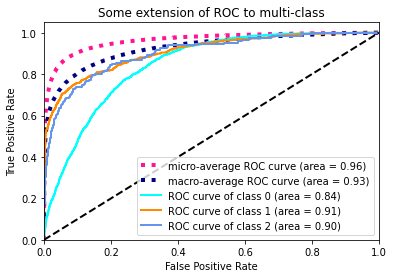

In [ ]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

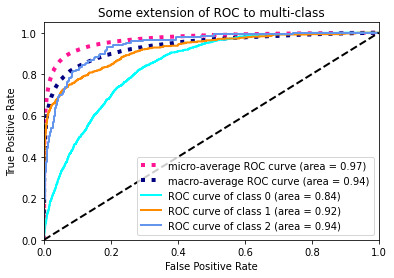

In [ ]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)


**Task 4 (MultilabelClassification).** Once we have the evaluation set up, we suggest that you experiment a bit with training your classifiers. We will use F1-score weighted as an evaluation metric. Our recommendation:

compare the quality of the bag-of-words and TF-IDF approaches and chose one of them.
for the chosen one, try L1 and L2-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).
You also could try other improvements of the preprocessing / model, if you want.

In [ ]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
      
    """
    classifier = OneVsRestClassifier(LogisticRegression(C=10, max_iter=600, solver='liblinear', penalty='l1'))
    model = classifier.fit(X_train, y_train)
    return model

In [ ]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [ ]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [ ]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(10):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	c#


Title:	contenttype applicationjson required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	ruby-on-rails


Title:	sessions sinatra used pass variable
True labels:	ruby,session
Predicted labels:	php,ruby,session


Title:	getting error type json exist postgresql rake db migrate
True labels:	json,ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails


Title:	library found
True labels:	c++,ios,iphone,xcode
Predicted labels:	


Title:	csproj file programmatic addingdeleting files
True labels:	c#
Predicted labels:	c#


Title:	typeerror makedirs got unexpected keyword argument exists_ok
True labels:	django,python
Predicted labels:	python


Title:	pan div using jquery
True labels:	html,javascript,jquery
Predicted labels:	javascript,jquery


Title:	hibernate intermediateadvanced tutorials
True labels:	hibernate,ja

In [ ]:
def print_evaluation_scores(y_val, predicted):
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    print('Accuracy:',accuracy_score(y_val, predicted))
    print('F1 Score:',f1_score(y_val, predicted, average='weighted'))
    print('Precision:',average_precision_score(y_val, predicted,average='weighted'))
    print('Recall:',recall_score(y_val, predicted,average='weighted'))

In [ ]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
Accuracy: 0.3329666666666667
F1 Score: 0.6440753491432782
Precision: 0.48799472154223383
Recall: 0.5778328490856264
Tfidf
Accuracy: 0.33903333333333335
F1 Score: 0.6437525209428367
Precision: 0.4846343028270865
Recall: 0.5866347632883268


In [ ]:
test_predictions = classifier_tfidf.predict(X_test_tfidf)
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

Current answer for task MultilabelClassification is:
 0	mysql,php
1	html,javascript,jquery
2	python
3	javascript,jquery
4	android
5	php,xml
6	json,web-ser...


#**Analysis of the most important features¶**
Finally, it is usually a good idea to look at the features (words or n-grams) that are used with the largest weigths in your logistic regression model.

Implement the function print_words_for_tag to find them. Get back to sklearn documentation on OneVsRestClassifier and LogisticRegression if needed.

In [ ]:
arr = np.array(mlb.classes)
print(arr)
result = np.where(arr == 'c')[0][0]
print(result)

['.net' 'ajax' 'algorithm' 'android' 'angularjs' 'apache' 'arrays'
 'asp.net' 'asp.net-mvc' 'c' 'c#' 'c++' 'class' 'cocoa-touch'
 'codeigniter' 'css' 'csv' 'database' 'date' 'datetime' 'django' 'dom'
 'eclipse' 'entity-framework' 'excel' 'facebook' 'file' 'forms' 'function'
 'generics' 'google-maps' 'hibernate' 'html' 'html5' 'image' 'ios'
 'iphone' 'java' 'javascript' 'jquery' 'json' 'jsp' 'laravel' 'linq'
 'linux' 'list' 'loops' 'maven' 'mongodb' 'multithreading' 'mysql'
 'node.js' 'numpy' 'objective-c' 'oop' 'opencv' 'osx' 'pandas' 'parsing'
 'performance' 'php' 'pointers' 'python' 'python-2.7' 'python-3.x' 'qt'
 'r' 'regex' 'rest' 'ruby' 'ruby-on-rails' 'ruby-on-rails-3' 'selenium'
 'servlets' 'session' 'sockets' 'sorting' 'spring' 'spring-mvc' 'sql'
 'sql-server' 'string' 'swift' 'swing' 'twitter-bootstrap' 'uitableview'
 'unit-testing' 'validation' 'vb.net' 'visual-studio' 'visual-studio-2010'
 'wcf' 'web-services' 'windows' 'winforms' 'wordpress' 'wpf' 'xaml'
 'xcode' 'xml']
9


In [ ]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    arr = np.array(tags_classes)
    tag_index = np.where(arr == tag)[0][0]
    
    model = classifier.estimators_[tag_index]
    top_positive_words = [index_to_words[x] for x in model.coef_.argsort().tolist()[0][-8:]]
    top_negative_words = [index_to_words[x] for x in model.coef_.argsort().tolist()[0][:8]]

    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [ ]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes_, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes_, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes_, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'python', mlb.classes_, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'r', mlb.classes_, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'java', mlb.classes_, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	open url, fscanf, md5 hash, malloc, cc++, installing ruby, php call, c
Top negative words:	swift, php, javascript, ruby, java, according, objective c, nsstring

Tag:	c++
Top positive words:	boostasio, mfc, qt, using jni, stl, c++11, stdstring, c++
Top negative words:	php, java, 3rd party, c++ stl, jquery, javascript, c#, django

Tag:	linux
Top positive words:	dlopen, write simple, killed, identifier string, play services, simple calculator, kernel space, linux
Top negative words:	aspnet, displaying, codeigniter, echo, javascript, python run, java heap, c#

Tag:	python
Top positive words:	pythons, pyqt, matplotlib, beautifulsoup, tkinter, pandas, numpy, python
Top negative words:	php, c#, unable import, use new, python pil, java, django python, way return

Tag:	r
Top positive words:	nas, rmarkdown, dplyr, rstudio, ggplot, shiny, ggplot2, r
Top negative words:	android, php, java, javascript, python, c++, c#, matplotlib

Tag:	java
Top positive words:	jar, play f